# Record Sound

In [12]:
import pyaudio
import numpy as np
import matplotlib.pyplot as plt

In [68]:
# Parameters for recording
CHUNK = 1024            # Number of audio samples per buffer
FORMAT = pyaudio.paInt16  # 16-bit resolution
CHANNELS = 1            # Mono audio
RATE = 44100            # Sampling rate in Hz
RECORD_SECONDS = 5      # Duration of recording in seconds
AUDIO_FILE = './utils/assets/test_SIV.mp3'

In [14]:
def record_audio():
    # Initialize the audio stream
    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("Recording...")
    frames = []

    # Record audio in chunks and append to frames
    for _ in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("Finished recording.")
    stream.stop_stream()
    stream.close()
    p.terminate()

    return frames




In [15]:
from pydub import AudioSegment

def from_mp3(file_path):

    audio_file_path = file_path  # Replace with your MP3 file path
    audio = AudioSegment.from_mp3(audio_file_path)
    
    # Convert the audio to raw PCM data (in this case, 16-bit mono)
    audio = audio.set_channels(1)  # Ensure mono
    audio = audio.set_frame_rate(RATE)  # Match the desired sample rate
    
    # Convert audio to raw bytes
    raw_audio_data = audio.raw_data
    
    # Process the audio data in chunks as you would with live input
    frames = [raw_audio_data[i:i + CHUNK] for i in range(0, len(raw_audio_data), CHUNK)]
    return frames


In [16]:
frames = from_mp3('./utils/assets/test_SIV.mp3')
#frames = record_audio()

In [17]:


audio_data = b''.join(frames)
audio_array = np.frombuffer(audio_data, dtype=np.int16)

print(f"length of audio array: {len(audio_array)}")
print(f"CHUNK * RATE * RECORD_SECONDS: {RATE * RECORD_SECONDS}")
print(len(audio_array) == RATE * RECORD_SECONDS)
print(audio_array)

length of audio array: 876672
CHUNK * RATE * RECORD_SECONDS: 220500
False
[0 0 0 ... 0 0 0]


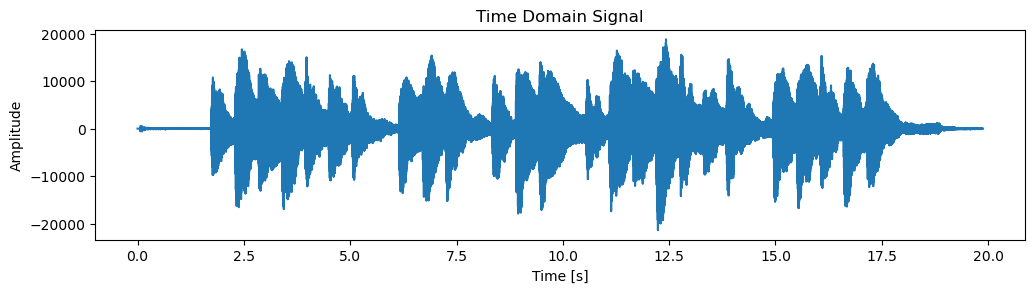

In [18]:
# Create a time axis for the time-domain plot
def plot_signal(audio_signal):
   
    time_axis = np.linspace(0, len(audio_signal) / RATE, num=len(audio_signal))
    # Plot the time-domain signal
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, audio_array)
    plt.title('Time Domain Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    
plot_signal(audio_array)

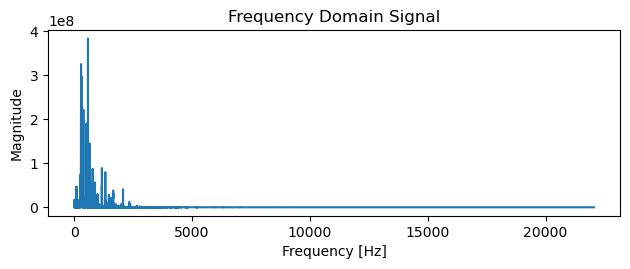

In [19]:

def plot_fft(audio_array):
    
    # Compute the Fourier Transform for the frequency-domain plot
    fft_data = np.fft.fft(audio_array)
    fft_freq = np.fft.fftfreq(len(audio_array), d=1/RATE)
    
    # Use only the positive half of the spectrum
    positive_freqs = fft_freq[:len(fft_freq)//2]
    fft_magnitude = np.abs(fft_data[:len(fft_data)//2])
    
    # Plot the frequency-domain signal
    plt.subplot(2, 1, 2)
    plt.plot(positive_freqs, fft_magnitude)
    plt.title('Frequency Domain Signal')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    
    plt.tight_layout()
    plt.show()
    
plot_fft(audio_array)

In [20]:
gaussian_kernel = [0.00766381, 0.01189906, 0.0176778, 0.02512993, 0.03418235,
 0.04448978, 0.0554072, 0.06602672, 0.07528715, 0.08214282,
 0.08575629, 0.0856663, 0.08188448, 0.07489293, 0.0655432,
 0.05488606, 0.04397888, 0.03371893, 0.02473723, 0.01736505,
 0.01166403]

# Using Hanning Window

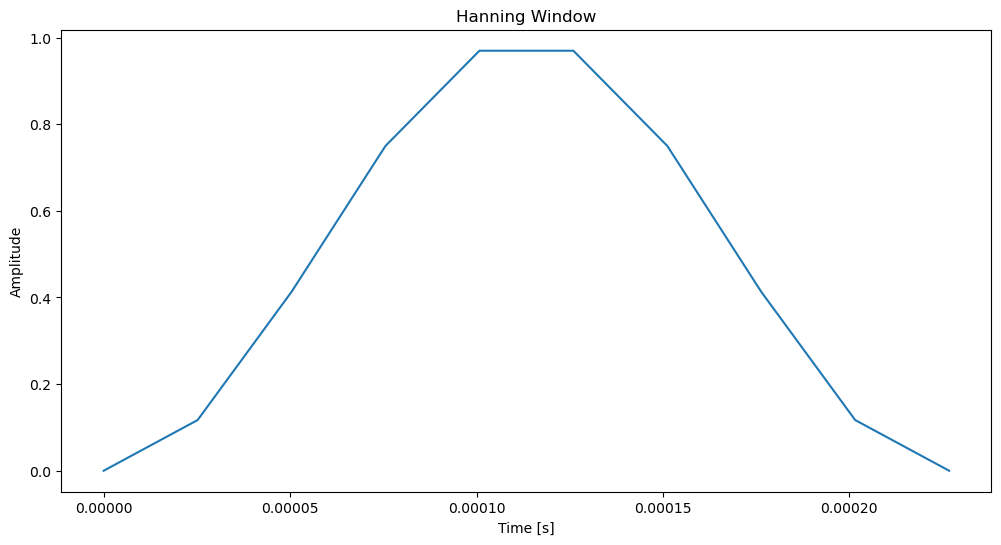

In [21]:
hanning_window = np.hanning(10)
time_axis = np.linspace(0,10 / RATE, num=10)

#plot the hanning window
plt.figure(figsize=(12, 6))
plt.plot(time_axis, hanning_window)
plt.title('Hanning Window')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.show()




# Musical Notes Analysis

In [22]:
def get_dominant_freq(data, fs):

    window = np.hanning(len(data))
    data = data * window

    # Compute FFT
    fft_spectrum = np.fft.rfft(data)
    fft_magnitude = np.abs(fft_spectrum)
    freqs = np.fft.rfftfreq(len(data), d=1/fs)

    # Ignore frequencies below 50 Hz
    idx = np.where(freqs > 50)
    freqs = freqs[idx]
    fft_magnitude = fft_magnitude[idx]

    # Find the peak frequency
    peak_idx = np.argmax(fft_magnitude)
    peak_freq = freqs[peak_idx]
    return peak_freq

In [23]:
def freq_to_note_name(frequency):
    A4 = 440.0
    C0 = A4 * pow(2, -4.75)  # Frequency of C0

    if frequency == 0:
        return None

    # Calculate the number of semitones from C0
    h = round(12 * np.log2(frequency / C0))
    octave = h // 12
    n = h % 12
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    note_name = note_names[n] + str(octave)
    return note_name

In [24]:

def get_notes(audio_signal):

    #notes = [freq_to_note_name(get_dominant_freq(np.frombuffer(data, dtype=np.int16), RATE)) for data in frames]
    notes=[]
    for i in range(0, len(audio_signal), CHUNK):
        audio_chunk = audio_signal[i:i + CHUNK]
        dominant_freq = get_dominant_freq(audio_chunk, RATE)
        note = freq_to_note_name(dominant_freq)
        notes.append(note)
    result= []
    idx= 0
    
    while idx<len(notes):
        n = notes[idx]
        counter = 0
        # Count consecutive occurrences of the note
        while idx < len(notes) and notes[idx] == n:
            counter += 1
            idx += 1
        result.append((n,counter))
    return result

result = get_notes(audio_array)
result


[('F2', 5),
 ('F3', 1),
 ('F2', 1),
 ('C3', 2),
 ('F2', 2),
 ('C3', 3),
 ('D4', 1),
 ('F2', 8),
 ('C4', 1),
 ('F2', 1),
 ('D4', 1),
 ('C3', 1),
 ('F2', 5),
 ('D4', 1),
 ('C4', 1),
 ('C3', 2),
 ('A3', 1),
 ('F2', 3),
 ('D4', 1),
 ('F2', 2),
 ('D4', 1),
 ('F2', 1),
 ('D4', 2),
 ('F2', 8),
 ('D4', 1),
 ('F2', 1),
 ('C3', 1),
 ('F2', 1),
 ('G4', 1),
 ('F2', 2),
 ('D4', 1),
 ('F2', 4),
 ('D4', 2),
 ('C3', 2),
 ('F2', 2),
 ('D4', 1),
 ('F2', 1),
 ('E5', 1),
 ('F4', 5),
 ('E5', 2),
 ('F4', 16),
 ('D5', 3),
 ('D4', 2),
 ('D5', 5),
 ('D4', 2),
 ('D5', 3),
 ('D4', 3),
 ('D5', 3),
 ('D4', 3),
 ('C5', 23),
 ('D5', 3),
 ('D4', 1),
 ('D5', 13),
 ('D4', 7),
 ('D5', 1),
 ('F4', 2),
 ('D4', 1),
 ('F4', 6),
 ('D4', 1),
 ('F4', 12),
 ('F5', 1),
 ('F4', 23),
 ('E5', 1),
 ('F4', 7),
 ('E5', 26),
 ('E6', 3),
 ('F4', 8),
 ('E6', 2),
 ('F2', 1),
 ('D5', 1),
 ('D4', 1),
 ('D5', 1),
 ('D4', 2),
 ('D5', 4),
 ('D4', 3),
 ('D5', 11),
 ('C#5', 1),
 ('D5', 12),
 ('D4', 11),
 ('D5', 10),
 ('D4', 3),
 ('D5', 1),
 ('D4

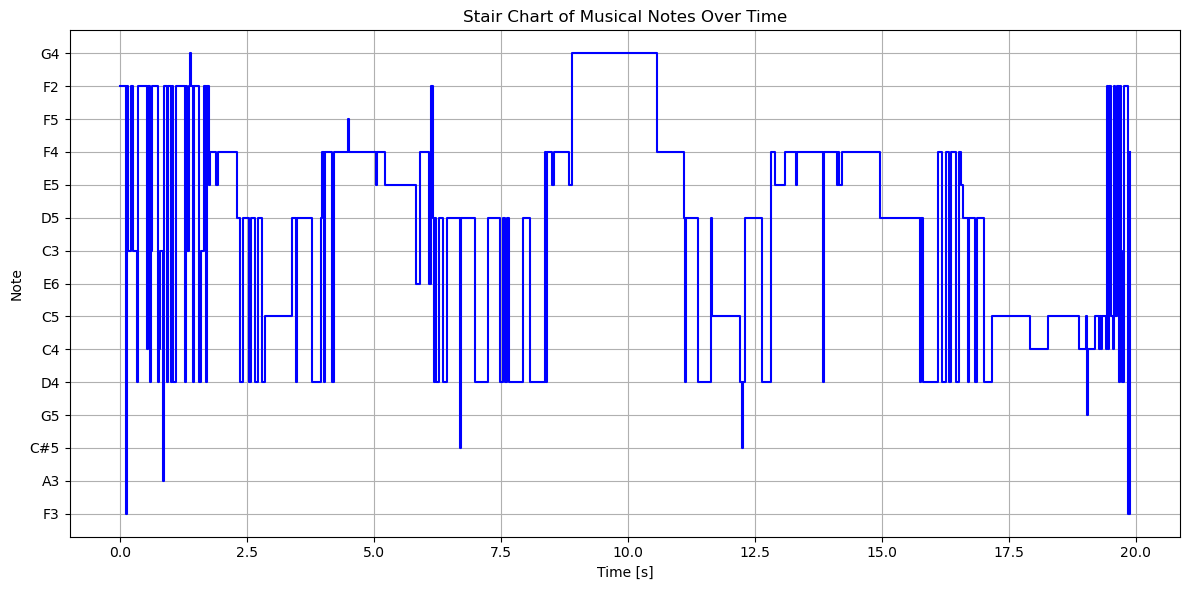

In [25]:

def plot_notes_chart(notes):
    # Now we create the time chart with vertical lines for each note change
    times = []  # to store the time for each note change
    note_changes = []  # to store the note at each change
    current_time = 0  # starting time
    
    for note, count in notes:
        times.append(current_time)
        note_changes.append(note)
        current_time += count * (CHUNK / RATE)  # each chunk corresponds to CHUNK/RATE seconds
    
    # Convert the note changes into numeric values for plotting
    note_to_num = {note: i for i, note in enumerate(set(note_changes))}
    numeric_notes = [note_to_num[n] for n in note_changes]
    
    # Plotting the "stair" chart
    plt.figure(figsize=(12, 6))
    plt.step(times, numeric_notes, where='post', color='blue', label='Musical Notes')
    
    # Label the y-axis with note names
    plt.yticks(list(note_to_num.values()), list(note_to_num.keys()))
    
    plt.title('Stair Chart of Musical Notes Over Time')
    plt.xlabel('Time [s]')
    plt.ylabel('Note')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_notes_chart(result)

In [26]:

def plot_note_window(start_time, end_time):
    # Filter the times and note_changes to include only data within the specified time window
    filtered_times = []
    filtered_notes = []

    for time, note in zip(times, note_changes):
        if start_time <= time <= end_time:
            filtered_times.append(time)
            filtered_notes.append(note)

    # Convert the filtered notes into numeric values for plotting
    filtered_numeric_notes = [note_to_num[n] for n in filtered_notes]

    # Plotting the "stair" chart for the specific time window
    plt.figure(figsize=(12, 6))
    plt.step(filtered_times, filtered_numeric_notes, where='post', color='blue', label='Musical Notes')

    # Label the y-axis with note names
    plt.yticks(list(note_to_num.values()), list(note_to_num.keys()))

    # Set titles and labels
    plt.title(f'Stair Chart of Musical Notes Over Time (Window: {start_time}s to {end_time}s)')
    plt.xlabel('Time [s]')
    plt.ylabel('Note')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [27]:
plot_note_window(1,3)

NameError: name 'times' is not defined

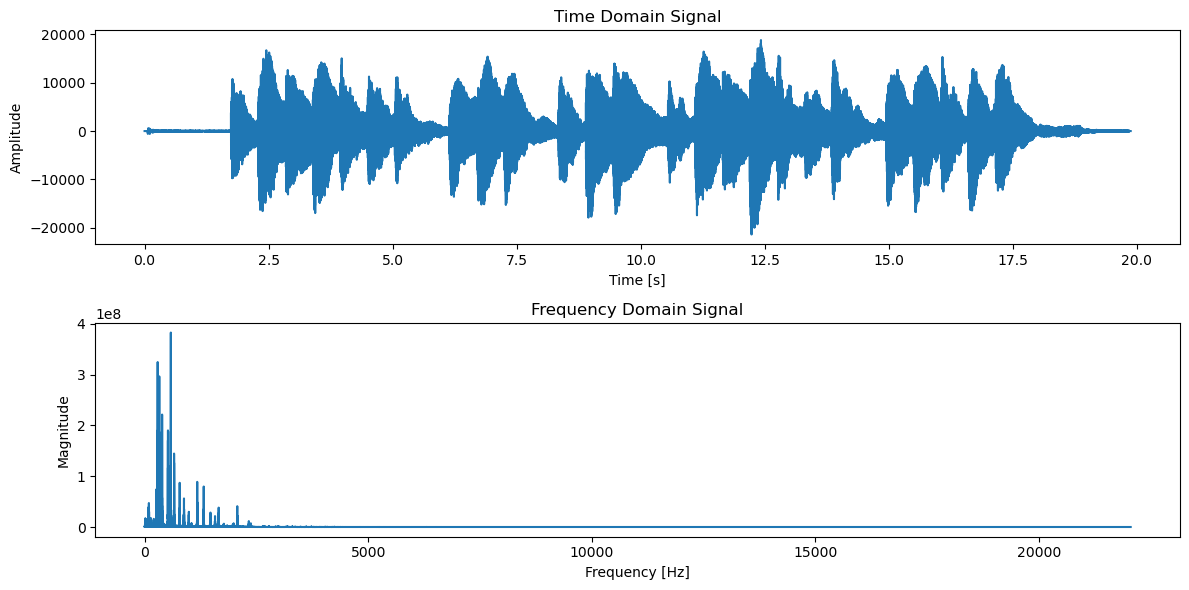

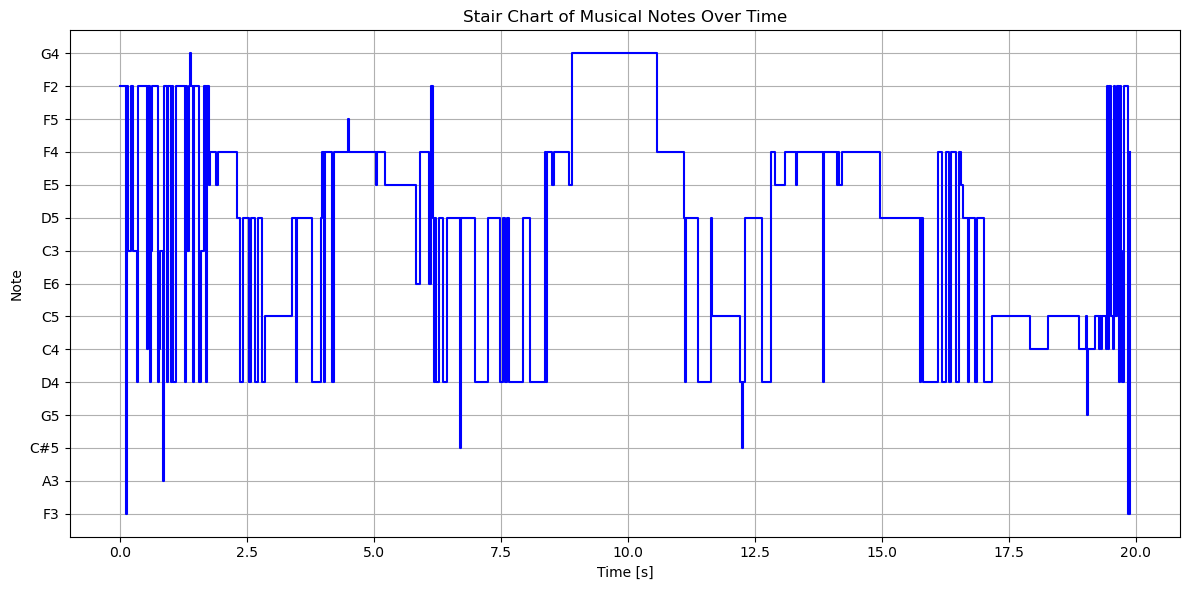

In [29]:
def visualize_result(audio_array, window=None):
    if window is not None:
        idx_start = int(window[0] * RATE)
        idx_end = int(window[1] * RATE)
        print(len(audio_array))
        print(f"start: {idx_start} end: {idx_end}")

    
        plot_signal(audio_array[idx_start:idx_end])
    else:
        plot_signal(audio_array)
        
    plot_fft(audio_array)
    notes = get_notes(audio_array)
    if window:
        plot_note_window(*window)
    else:
         plot_notes_chart(notes)
    
visualize_result(audio_array)
    

In [30]:
import numpy as np
import librosa

def calculate_bpm(frames, rate=RATE):
    """
    Calculate the BPM of audio data from raw PCM frames.
    
    :param frames: List of raw audio data chunks.
    :param rate: Sampling rate of the audio.
    :return: Estimated BPM.
    """
    # Concatenate all the frames into a single audio signal
    raw_audio_data = b"".join(frames)
    
    # Convert raw audio bytes to numpy array
    audio_samples = np.frombuffer(raw_audio_data, dtype=np.int16)  # Assuming 16-bit audio
    
    # Normalize the audio to float values between -1 and 1
    audio_samples = librosa.util.buf_to_float(audio_samples, n_bytes=2)
    
    # Use librosa to calculate the tempo (BPM)
    tempo, beats = librosa.beat.beat_track(y=audio_samples, sr=rate)
    
    return tempo, beats

In [31]:
tempo, beats = calculate_bpm(frames)
tempo


array([109.95678191])

In [32]:
beats

array([ 151,  199,  247,  294,  342,  389,  436,  484,  532,  579,  626,
        674,  721,  768,  816,  864,  911,  958, 1006, 1053, 1100, 1148,
       1195, 1243, 1290, 1337, 1385, 1432])

In [33]:
def beats_per_chunk(bpm, rate=RATE):
    
    period = 1/rate
    seconds_per_beat = 60/bpm
    beats_per_sample = seconds_per_beat/period
    return beats_per_sample * CHUNK

In [34]:
BEATS_PER_CHUNK = beats_per_chunk(tempo)[0]
BEATS_PER_CHUNK

24641536.000000004

In [35]:
new_notes_array = []
for note in result:
    new_notes_array.append((note[0] , note[1]*BEATS_PER_CHUNK))

new_notes_array

[('F2', 123207680.00000001),
 ('F3', 24641536.000000004),
 ('F2', 24641536.000000004),
 ('C3', 49283072.00000001),
 ('F2', 49283072.00000001),
 ('C3', 73924608.00000001),
 ('D4', 24641536.000000004),
 ('F2', 197132288.00000003),
 ('C4', 24641536.000000004),
 ('F2', 24641536.000000004),
 ('D4', 24641536.000000004),
 ('C3', 24641536.000000004),
 ('F2', 123207680.00000001),
 ('D4', 24641536.000000004),
 ('C4', 24641536.000000004),
 ('C3', 49283072.00000001),
 ('A3', 24641536.000000004),
 ('F2', 73924608.00000001),
 ('D4', 24641536.000000004),
 ('F2', 49283072.00000001),
 ('D4', 24641536.000000004),
 ('F2', 24641536.000000004),
 ('D4', 49283072.00000001),
 ('F2', 197132288.00000003),
 ('D4', 24641536.000000004),
 ('F2', 24641536.000000004),
 ('C3', 24641536.000000004),
 ('F2', 24641536.000000004),
 ('G4', 24641536.000000004),
 ('F2', 49283072.00000001),
 ('D4', 24641536.000000004),
 ('F2', 98566144.00000001),
 ('D4', 49283072.00000001),
 ('C3', 49283072.00000001),
 ('F2', 49283072.00000001

# Chord detection

In [87]:
import numpy as np
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
def get_dominant_freqs(data, fs, num_peaks=3, threshold=0.1):
    """
    Detect dominant frequencies in audio data.

    Parameters:
    - data: Array of audio samples.
    - fs: Sampling frequency (Hz).
    - num_peaks: Number of peaks to return.
    - threshold: Magnitude threshold as a fraction of the max FFT magnitude.

    Returns:
    - A sorted list of dominant frequencies.
    """
    # Apply a Hanning window to reduce spectral leakage
    window = np.hanning(len(data))
    data = data * window

    # Compute FFT and get magnitudes
    fft_spectrum = rfft(data)
    fft_magnitude = np.abs(fft_spectrum)

    # Compute frequency bins
    freqs = rfftfreq(len(data), d=1/fs)

    # Apply a magnitude threshold to filter noise
    magnitude_threshold = threshold * np.max(fft_magnitude)
    valid_indices = np.where(fft_magnitude > magnitude_threshold)[0]

    # Detect peaks from the valid indices
    peak_indices = valid_indices[np.argsort(fft_magnitude[valid_indices])[-num_peaks:]]
    peak_freqs = freqs[peak_indices]

    return sorted(peak_freqs)

In [88]:
def get_chord_frequencies(root_frequency, chord_type="major"):
    """
    Calculate the frequencies of a chord based on the root frequency and chord type.

    :param root_frequency: Frequency of the root note in Hz.
    :param chord_type: Type of chord ("major", "minor", "diminished", "augmented").
    :return: List of frequencies for the chord.
    """
    # Ratios for common chord intervals
    intervals = {
        "major": [1.0, 5/4, 3/2],        # Root, major third, perfect fifth
        "minor": [1.0, 6/5, 3/2],        # Root, minor third, perfect fifth
        "diminished": [1.0, 6/5, 7/5],   # Root, minor third, diminished fifth
        "augmented": [1.0, 5/4, 25/16],  # Root, major third, augmented fifth
    }
    if chord_type not in intervals:
        raise ValueError(f"Unsupported chord type: {chord_type}")
    
    # Calculate frequencies based on the intervals
    return [root_frequency * ratio for ratio in intervals[chord_type]]

# Example usage:

In [89]:
def freqs_to_chord(frequencies, tolerance=5.0):
    """
    Detect the chord name from a list of frequencies.

    :param frequencies: List of detected frequencies.
    :param tolerance: Allowable frequency deviation in Hz for matching.
    :return: Detected chord name or "Unknown".
    """
    # Root note frequencies for standard tuning
    root_notes = {
        "C": 261.63, "C#": 277.18, "D": 293.66, "D#": 311.13, "E": 329.63,
        "F": 349.23, "F#": 369.99, "G": 392.00, "G#": 415.30, "A": 440.00,
        "A#": 466.16, "B": 493.88
    }

    # Iterate through root notes and chord types
    for root_name, root_frequency in root_notes.items():
        for chord_type in ["major", "minor", "diminished", "augmented"]:
            # Calculate chord frequencies for this root and type
            chord_frequencies = get_chord_frequencies(root_frequency, chord_type)

            # Check if the detected frequencies match the chord frequencies
            if all(
                any(abs(freq - chord_freq) <= tolerance for freq in frequencies)
                for chord_freq in chord_frequencies
            ):
                return f"{root_name} {chord_type.capitalize()}"
    
    return "Unknown"

In [90]:
detected_frequencies = [261.0, 329.5, 392.2]  # C Major chord frequencies with slight deviations
chord_name = freqs_to_chord(detected_frequencies)

print(chord_name)  # Output: "C Major"

C Major


In [91]:
def get_chords(audio_signal):
    """
    Detect chords from an audio signal by analyzing chunks of data.
    
    :param audio_signal: The full audio signal as a numpy array.
    :return: List of detected chords.
    """
    chords = []
    for i in range(0, len(audio_signal), CHUNK):
        # Extract a chunk of audio data
        audio_chunk = audio_signal[i:i + CHUNK]

        # Ensure the chunk is of the correct format
        if len(audio_chunk) < CHUNK:
            # Pad the last chunk with zeros if it's smaller than CHUNK
            audio_chunk = np.pad(audio_chunk, (0, CHUNK - len(audio_chunk)))

        # Apply dominant frequency detection
        dominant_freqs = get_dominant_freqs(audio_chunk.astype(float), RATE)
        
        # Map the detected frequencies to a chord name
        chord = freqs_to_chord(dominant_freqs)
        chords.append(chord)
    
    return chords

In [92]:
def plot_spectrogram(audio_signal):
    plt.specgram(audio_signal, Fs=RATE, NFFT=CHUNK, noverlap=CHUNK//2, cmap='plasma')
    plt.title('Spectrogram')
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    plt.colorbar(label='Amplitude')
    plt.show()

In [95]:
import numpy as np

# Assuming from_mp3 function and RATE are already defined
frames = from_mp3('./utils/assets/test_SIV.mp3')  # Replace with your MP3 processing logic
audio_data = b''.join(frames)
audio_array = np.frombuffer(audio_data, dtype=np.int16)

# Normalize audio array for better FFT stability
audio_array = audio_array / np.max(np.abs(audio_array))

# Process audio in chunks and print results
CHUNK = 4096  # Define your chunk size
for i in range(0, len(audio_array), CHUNK):
    audio_chunk = audio_array[i:i + CHUNK]
    if len(audio_chunk) < CHUNK:  # Skip last chunk if it's smaller than CHUNK
        continue
    dominant_freqs = get_dominant_freqs(audio_chunk.astype(float), RATE)
    print(f"Chunk {i // CHUNK}: Detected Frequencies: {dominant_freqs}")
    
    # Assuming freqs_to_chord function is defined for chord mapping
    chord = freqs_to_chord(dominant_freqs)
    print(f"Detected Chord: {chord}")

TypeError: sequence item 1: expected a bytes-like object, int found

In [ ]:
plot_spectrogram(audio_array)

In [94]:
from scipy.signal import butter, lfilter

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return lfilter(b, a, data)

filtered_audio = bandpass_filter(audio_array, 50, 5000, RATE)

In [55]:
def is_silent(chunk, threshold=100):
    energy = np.sum(chunk ** 2)
    return energy < threshold

In [56]:
# Preprocess the audio signal


# Iterate through chunks and detect chords
for i in range(0, len(filtered_audio), CHUNK):
    audio_chunk = filtered_audio[i:i + CHUNK]

    if len(audio_chunk) < CHUNK:
        audio_chunk = np.pad(audio_chunk, (0, CHUNK - len(audio_chunk)))

    # Skip silent chunks
    if is_silent(audio_chunk):
        print(f"Chunk {i // CHUNK}: Silent")
        continue

    # Detect frequencies
    dominant_freqs = get_dominant_freqs(audio_chunk.astype(float), RATE)
    print(f"Chunk {i // CHUNK}: Detected Frequencies: {dominant_freqs}")

    # Map frequencies to chords
    chord = freqs_to_chord(dominant_freqs)
    print(f"Detected Chord: {chord}")

Chunk 0: Silent
Chunk 1: Silent
Chunk 2: Detected Frequencies: [215.33203125, 258.3984375, 301.46484375]
Detected Chord: Unknown
Chunk 3: Detected Frequencies: [43.06640625, 86.1328125, 129.19921875]
Detected Chord: Unknown
Chunk 4: Detected Frequencies: [43.06640625, 129.19921875, 172.265625]
Detected Chord: Unknown
Chunk 5: Detected Frequencies: [43.06640625, 86.1328125, 129.19921875]
Detected Chord: Unknown
Chunk 6: Detected Frequencies: [43.06640625, 129.19921875, 172.265625]
Detected Chord: Unknown
Chunk 7: Detected Frequencies: [43.06640625, 86.1328125, 129.19921875]
Detected Chord: Unknown
Chunk 8: Detected Frequencies: [43.06640625, 86.1328125, 129.19921875]
Detected Chord: Unknown
Chunk 9: Detected Frequencies: [43.06640625, 86.1328125, 172.265625]
Detected Chord: Unknown
Chunk 10: Detected Frequencies: [43.06640625, 86.1328125, 129.19921875]
Detected Chord: Unknown
Chunk 11: Detected Frequencies: [43.06640625, 86.1328125, 129.19921875]
Detected Chord: Unknown
Chunk 12: Detect

In [83]:
def generate_chord_signal(frequencies, duration, rate=RATE):
    t = np.linspace(0, duration, int(rate * duration), endpoint=False)
    signal = sum(np.sin(2 * np.pi * f * t) for f in frequencies)
    return (signal * 32767).astype(np.int16)

In [84]:
c_major_frequencies = [261.63, 329.63, 392.00]
synthetic_audio = generate_chord_signal(c_major_frequencies, duration=5)

In [86]:

for i in range(0, len(synthetic_audio), CHUNK):
    audio_chunk = synthetic_audio[i:i + CHUNK]
    dominant_freqs = get_dominant_freqs(audio_chunk.astype(float), RATE)
    print(f"Chunk {i // CHUNK}: Detected Frequencies: {dominant_freqs}")
    chord = freqs_to_chord(dominant_freqs)
    print(f"Detected Chord: {chord}")



Chunk 0: Detected Frequencies: [0.0, 129.19921875, 915.1611328125]
Detected Chord: Unknown
Chunk 1: Detected Frequencies: [322.998046875, 527.5634765625, 915.1611328125]
Detected Chord: Unknown
Chunk 2: Detected Frequencies: [656.7626953125, 667.529296875, 1044.3603515625]
Detected Chord: Unknown
Chunk 3: Detected Frequencies: [0.0, 527.5634765625, 656.7626953125]
Detected Chord: Unknown
Chunk 4: Detected Frequencies: [1313.525390625, 1701.123046875, 2228.6865234375]
Detected Chord: Unknown
Chunk 5: Detected Frequencies: [139.9658203125, 258.3984375, 527.5634765625]
Detected Chord: Unknown
Chunk 6: Detected Frequencies: [592.1630859375, 721.3623046875, 1571.923828125]
Detected Chord: Unknown
Chunk 7: Detected Frequencies: [0.0, 258.3984375, 387.59765625]
Detected Chord: Unknown
Chunk 8: Detected Frequencies: [656.7626953125, 785.9619140625, 1701.123046875]
Detected Chord: Unknown
Chunk 9: Detected Frequencies: [0.0, 258.3984375, 387.59765625]
Detected Chord: Unknown
Chunk 10: Detected 

In [65]:
detected_frequencies = [261.63, 329.63, 392.00]  # Example: C Major
chord_name = freqs_to_chord(detected_frequencies)
print(f"Detected Chord: {chord_name}")

Detected Chord: C Major


# New try

In [71]:
from pydub import AudioSegment
import numpy as np
from scipy.fft import fft
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import median_filter

# Constants
RATE = 44100  # Desired sample rate (Hz)
CHUNK = 4096  # Chunk size (samples)

# Bandpass Filter for focusing on musical frequencies (20 Hz - 4000 Hz)
def bandpass_filter(signal, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Function to process MP3 file
def from_mp3(file_path):
    try:
        audio = AudioSegment.from_mp3(file_path)
    except Exception as e:
        raise ValueError(f"Error loading MP3 file: {e}")
    
    # Ensure the audio has content
    if len(audio) == 0:
        raise ValueError("The audio file is empty or could not be processed.")
    
    # Convert the audio to raw PCM data (16-bit mono)
    audio = audio.set_channels(1)  # Ensure mono
    audio = audio.set_frame_rate(RATE)  # Match the desired sample rate
    
    # Convert audio to raw PCM samples with explicit dtype
    raw_audio_data = np.array(audio.get_array_of_samples(), dtype=np.int16)
    return raw_audio_data, audio.frame_rate

# Map frequencies to chroma (notes)
def freq_to_chroma(frequency):
    A4 = 440.0
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    if frequency <= 0:
        return None
    # Calculate the number of half-steps away from A4
    half_steps = round(12 * np.log2(frequency / A4))
    note_index = (half_steps + 9) % 12  # Offset to start from C
    return notes[note_index]

# Define common chords
CHORDS = {
    'C': {'C', 'E', 'G'},
    'Cm': {'C', 'D#', 'G'},
    'D': {'D', 'F#', 'A'},
    'Dm': {'D', 'F', 'A'},
    'E': {'E', 'G#', 'B'},
    'Em': {'E', 'G', 'B'},
    'F': {'F', 'A', 'C'},
    'Fm': {'F', 'G#', 'C'},
    'G': {'G', 'B', 'D'},
    'Gm': {'G', 'A#', 'D'},
    'A': {'A', 'C#', 'E'},
    'Am': {'A', 'C', 'E'},
    'B': {'B', 'D#', 'F#'},
    'Bm': {'B', 'D', 'F#'}
}

# Detect the chord from notes
def detect_chord(notes):
    detected_chords = []
    note_set = set(notes)
    for chord_name, chord_notes in CHORDS.items():
        if chord_notes.issubset(note_set):
            detected_chords.append(chord_name)
    return detected_chords if detected_chords else ['Unknown']

# Detect the most prominent frequencies in a chunk
def detect_frequencies(raw_audio_data, frame_rate):
    # Apply windowing (Hamming window) to reduce spectral leakage
    window = np.hamming(len(raw_audio_data))
    raw_audio_data = raw_audio_data * window
    
    # Apply FFT
    n_fft = 2 ** int(np.ceil(np.log2(len(raw_audio_data))))  # Zero-padding for better resolution
    fft_result = fft(raw_audio_data, n=n_fft)
    magnitude = np.abs(fft_result)
    
    # Frequencies corresponding to FFT bins
    frequencies = np.fft.fftfreq(len(magnitude), 1 / frame_rate)
    
    # Filter out negative frequencies
    positive_freqs = frequencies[:len(frequencies) // 2]
    positive_magnitude = magnitude[:len(magnitude) // 2]
    
    # Find prominent frequencies using peak picking
    peaks, _ = find_peaks(positive_magnitude, height=0.1 * np.max(positive_magnitude))
    prominent_frequencies = positive_freqs[peaks]
    
    # Map frequencies to notes
    detected_notes = [freq_to_chroma(freq) for freq in prominent_frequencies if freq_to_chroma(freq) is not None]
    
    return detected_notes

# Smooth the detected chords sequence
def smooth_chord_sequence(chords, size=3):
    flattened_chords = [chord for sublist in chords for chord in sublist]
    return median_filter(flattened_chords, size=size)

# Main function to recognize chords
def recognize_chords(file_path):
    # Load audio data
    raw_audio_data, frame_rate = from_mp3(file_path)
    
    # Apply bandpass filter
    raw_audio_data = bandpass_filter(raw_audio_data, 20, 4000, RATE)
    
    # Split audio into overlapping chunks for analysis
    chunk_size = CHUNK
    overlap = chunk_size // 2
    chunks = [raw_audio_data[i:i + chunk_size] for i in range(0, len(raw_audio_data) - overlap, chunk_size - overlap)]
    
    detected_chords = []
    for chunk in chunks:
        notes = detect_frequencies(chunk, frame_rate)
        chord = detect_chord(notes)
        detected_chords.append(chord)
    
    # Smooth the detected chord sequence
    smoothed_chords = smooth_chord_sequence(detected_chords)
    return smoothed_chords

# Example usage
file_path = AUDIO_FILE  # Replace with your MP3 file path
try:
    chords = recognize_chords(file_path)
    print(f"Detected Chords: {chords}")
except Exception as e:
    print(f"Error: {e}")

Error: data type 'str224' not understood
